In [21]:
### Benjamin Tollison ###
import sympy as sp
from IPython.display import display, Math, Latex
from sympy.solvers.solveset import linsolve
from sympy.solvers.pde import pdsolve
from sympy import  lambdify, Matrix,sin,cos, sinh, cosh, exp, pi, symbols, integrate, Function, Eq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)

In [22]:
# Newton method for Eccentric anomoly
# part a
e = 0.5
mean_anomoly = np.pi/4
f = lambda E: E - e*np.sin(E) - mean_anomoly
Delta_k = lambda E: f(E)/(1-e*np.cos(E))
step_size = lambda E: np.linalg.norm(Delta_k(E))
true_anomoly = lambda E: 2*np.arctan2(np.sqrt(1+e**2)*np.tan(E/2),np.sqrt(1-e**2))
E_i = np.pi/4
tolerance = 1e-8
Newton_method_data = {'function error':[],'E_k':[],'step size':[],'f_k':[]}
while f(E_i) > tolerance or f(E_i) < -tolerance:
  Newton_method_data['function error'].append(f(E_i))
  Newton_method_data['E_k'].append(E_i)
  Newton_method_data['step size'].append(step_size(E_i))
  Newton_method_data['f_k'].append(true_anomoly(E_i))
  E_i = E_i - (f(E_i) / (1-e*np.cos(E_i)))
pd.DataFrame(Newton_method_data)

,function error,E_k,step size,f_k
0,-3.535534e-01,0.785398,5.469182e-01,0.982115
1,6.106908e-02,1.332316,6.924819e-02,1.585435
2,1.157898e-03,1.263068,1.364556e-03,1.513537
3,4.435719e-07,1.261704,5.231400e-07,1.512107


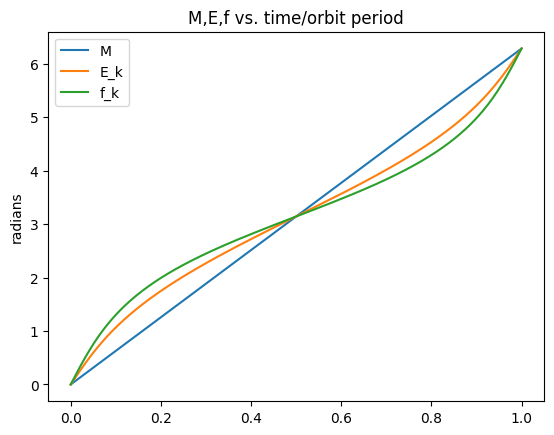

,M,E_i,f_k
0,0.000000,0.000000,0.000000
1,0.012566,0.025130,0.032442
2,0.025133,0.050244,0.064856
3,0.037699,0.075327,0.097216
4,0.050265,0.100363,0.129495
...,...,...,...
496,6.232920,6.182823,6.153690
497,6.245486,6.207858,6.185969
498,6.258053,6.232941,6.218329
499,6.270619,6.258055,6.250744


In [30]:
time = np.linspace(0,1,501)
M = lambda t: 2*np.pi*t
fractional_revolution = {'M':[],'E_i':[],'f_k':[]}
for t in time:
  fractional_revolution['M'].append(M(t))
  mean_anomoly = M(t)
  E_i = M(t)
  while f(E_i) > tolerance or f(E_i) < -tolerance:
    E_i = E_i - (f(E_i) / (1-e*np.cos(E_i)))
  fractional_revolution['E_i'].append(E_i)
  if true_anomoly(E_i) >= 0:
    fractional_revolution['f_k'].append(true_anomoly(E_i))
  else:
    fractional_revolution['f_k'].append(true_anomoly(E_i)+2*np.pi)
plt.plot(time,fractional_revolution['M'],label='M')
plt.plot(time,fractional_revolution['E_i'],label='E_k')
plt.plot(time,fractional_revolution['f_k'],label='f_k')
plt.legend()
plt.title('M,E,f vs. time/orbit period')
plt.ylabel('radians')
plt.show()
pd.DataFrame(fractional_revolution)